In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os

In [ ]:
!pip install fastai --upgrade
!pip install pytorch-lightning

In [ ]:
!unzip "/content/drive/MyDrive/Projects/BW to Color/train_color_images-v2.zip"
!unzip "/content/drive/MyDrive/Projects/BW to Color/validation_color_images-v2.zip"

In [ ]:
dfx = pd.read_csv("/content/drive/MyDrive/Projects/BW to Color/Training_small.csv")
dfx_val = pd.read_csv("/content/drive/MyDrive/Projects/BW to Color/Validation.csv")

In [ ]:
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import cv2

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, dataframe, data_dir_color):
        self.dataframe = dataframe
        self.data_dir_color = data_dir_color
    
    def __getitem__(self, item):
        img_id = self.dataframe.iloc[item]['image_id']
        img_path_c = os.path.join(self.data_dir_color, img_id)
        image = cv2.imread(img_path_c, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_lab = rgb2lab(image).astype("float32") # Converting RGB to L*a*b\
        img_lab = transforms.ToTensor()(img_lab)
        img_lab = transforms.RandomCrop(128)(img_lab)
        L = img_lab[[0], ...] / 50. - 1. #Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. #Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return self.dataframe.shape[0]

In [ ]:
train_images_color = "/content/train_color_images-v2"
validation_images_color = "/content/validation_color_images-v2"

In [ ]:
train_dataset = ColorizationDataset(dataframe = dfx, data_dir_color = train_images_color)
valid_dataset = ColorizationDataset(dataframe = dfx_val, data_dir_color = validation_images_color)

In [ ]:
validation_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = True, pin_memory = True) 

# Generator

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


import pytorch_lightning as pl
from pytorch_lightning import metrics

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=128):
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size))
    return net_G

In [ ]:
net_G = build_res_unet()
net_G.load_state_dict(torch.load("/content/drive/MyDrive/Projects/BW to Color/Models/res18-unet.pt", map_location=device))

<All keys matched successfully>

#Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(input_c, num_filters, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(num_filters, num_filters*2, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
                nn.BatchNorm2d(num_filters*2),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(num_filters*2, num_filters*4, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
                nn.BatchNorm2d(num_filters*4),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(num_filters*4, num_filters*8, kernel_size=(4,4), stride=(1,1), padding=(1,1), bias=False),
                nn.BatchNorm2d(num_filters*8),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(num_filters*8, 1, kernel_size=(4,4), stride=(1,1), padding=(1,1))
            )
        )

    def forward(self, x):
      return self.model(x)

# Training Code

In [ ]:
class GANLoss(nn.Module):
    def __init__(self,real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and 'Conv' in classname:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif 'BatchNorm2d' in classname:
        nn.init.normal_(m.weight.data, 1., 0.02)
        nn.init.constant_(m.bias.data, 0.)

def init_model(model):
  return model.apply(init_func)

In [ ]:
def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
class GANColorizer(pl.LightningModule):
  def __init__(self, train_dataset, val_dataset, validation_loader, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100., batch_size = 32):
    super().__init__()
    self.save_hyperparameters()

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.validation_loader_2 = validation_loader

    self.net_G = net_G
    self.net_D = init_model(Discriminator(input_c=3, n_down=3, num_filters=64))

    self.lr_G = lr_G
    self.lr_D = lr_D
    self.beta1 = beta1
    self.beta2 = beta2
    self.lambda_L1 = lambda_L1
    self.batch_size = batch_size

    self.GANCriterion = GANLoss()
    self.L1Criterion = nn.L1Loss()


  def forward(self, z):
    return self.net_G(z)


  def configure_optimizers(self):
    optimizer_G = optim.Adam(self.net_G.parameters(), lr=self.lr_G, betas=(self.beta1, self.beta2))
    optimizer_D = optim.Adam(self.net_D.parameters(), lr=self.lr_D, betas=(self.beta1, self.beta2))

    return [optimizer_G, optimizer_D] 


  def training_step(self, batch, batch_idx, optimizer_idx):
    L = batch['L']
    ab = batch['ab']

    fake_color = self.forward(L)
    fake_image = torch.cat([L, fake_color], dim = 1)
    real_image = torch.cat([L, ab], dim = 1)

    if optimizer_idx == 0: #train generator
      fake_preds = self.net_D(fake_image)
      loss_G_gc = self.GANCriterion(fake_preds, True)
      loss_G_l1 = self.L1Criterion(fake_color, ab) * self.lambda_L1
      loss_G = loss_G_gc + loss_G_l1
      self.log('Generator Loss', loss_G, prog_bar = True)
      return {'loss': loss_G}

    if optimizer_idx == 1: #train discriminator
      fake_preds = self.net_D(fake_image.detach())
      loss_D_f = self.GANCriterion(fake_preds, False)
            
      real_preds = self.net_D(real_image)
      loss_D_r = self.GANCriterion(real_preds, True)

      loss_D = (loss_D_f + loss_D_r) * 0.5
      self.log('Disciminator Loss Real', loss_D_r, prog_bar = True)
      self.log('Discriminator Loss Fake', loss_D_f, prog_bar = True)
      self.log('Discriminator Loss', loss_D, prog_bar = True)
      return {'loss': loss_D}

  def validation_step(self, batch, batch_idx):
    L = batch['L']
    ab = batch['ab']

    fake_color = self.forward(L)

    fake_image = torch.cat([L, fake_color], dim = 1)
    fake_preds = self.net_D(fake_image)
    val_loss_G = self.GANCriterion(fake_preds, True) + (self.L1Criterion(fake_color, ab) * self.lambda_L1)
    self.log('Validation Generator Loss', val_loss_G)
    return {'val_loss': val_loss_G}

  def validation_epoch_end(self, outputs):

    current_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    print(f"Validation Generator Loss: {current_val_loss}")

    sample = next(iter(self.validation_loader_2))
    L = sample['L'].to(device)
    ab = sample['ab'].to(device)

    fake_color = self.forward(L).detach()

    fake_images = lab_to_rgb(L, fake_color)
    real_images = lab_to_rgb(L, ab)

    fig = plt.figure(figsize=(15, 8))

    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_images[i])
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_images[i])
        ax.axis("off")

    plt.show()

    return {"val_loss_epoch":current_val_loss}

  def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True, pin_memory = True)
      
  def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = True, pin_memory = True)    

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.

  | Name         | Type          | Params
-----------------------------------------------
0 | net_G        | DynamicUnet   | 31.1 M
1 | net_D        | Discriminator | 2.8 M 
2 | GANCriterion | GANLoss       | 0     
3 | L1Criterion  | L1Loss        | 0     
-----------------------------------------------
33.9 M    Trainable params
0         Non-trainable params
33.9 M    Total params
135.461   Total estimated model params size (MB)


Validation Generator Loss: 10.80899429321289


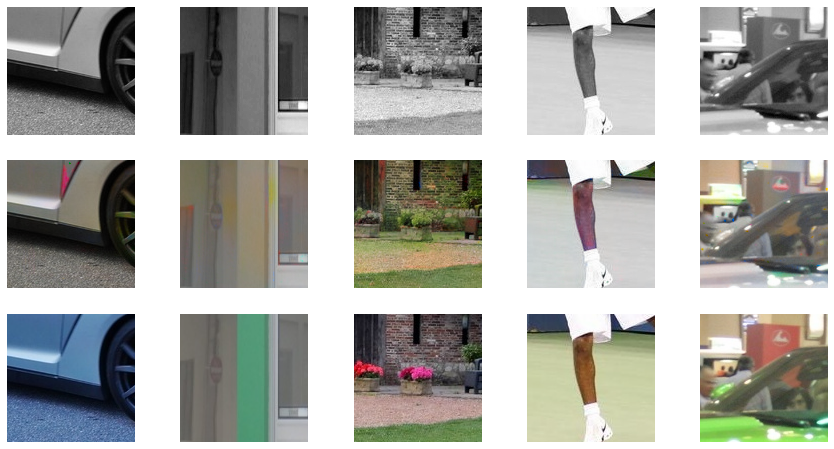

Validation Generator Loss: 12.080772399902344


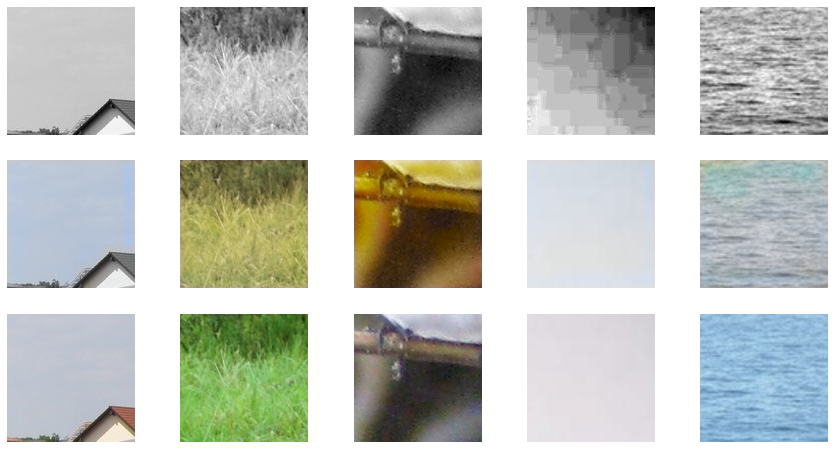

Validation Generator Loss: 11.869266510009766


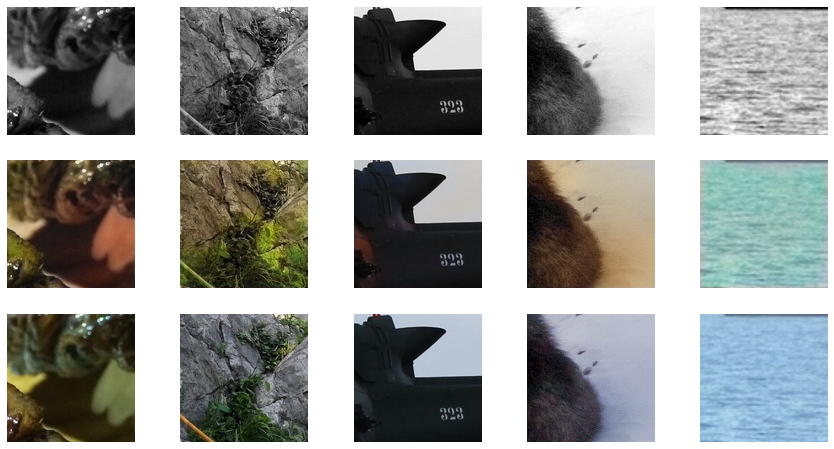

Validation Generator Loss: 12.998764991760254


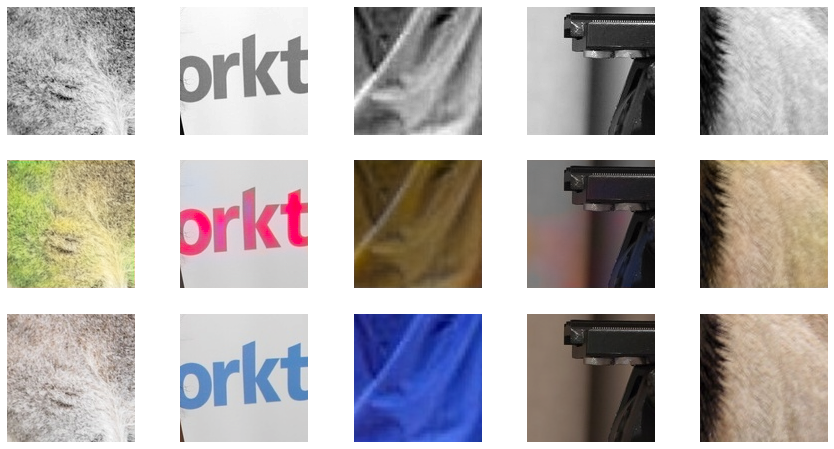

Validation Generator Loss: 12.177057266235352


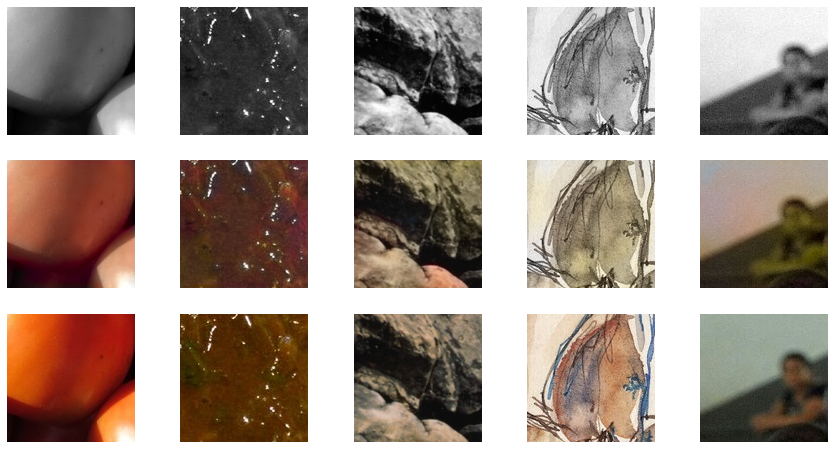

Validation Generator Loss: 14.504579544067383


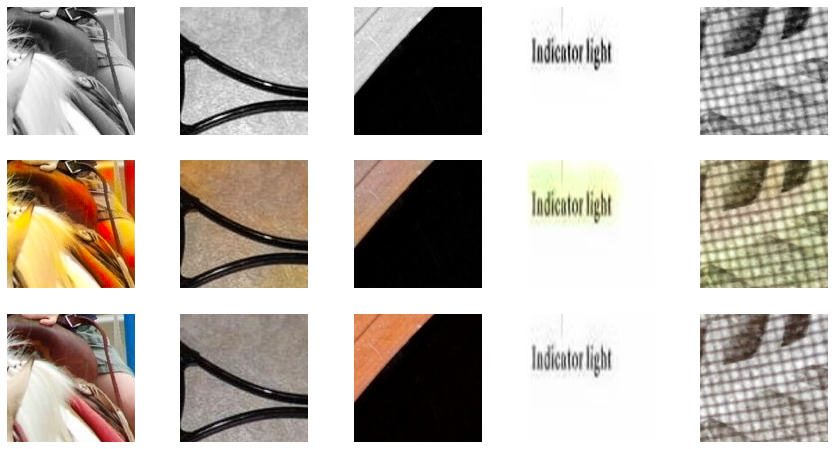

Validation Generator Loss: 12.929342269897461


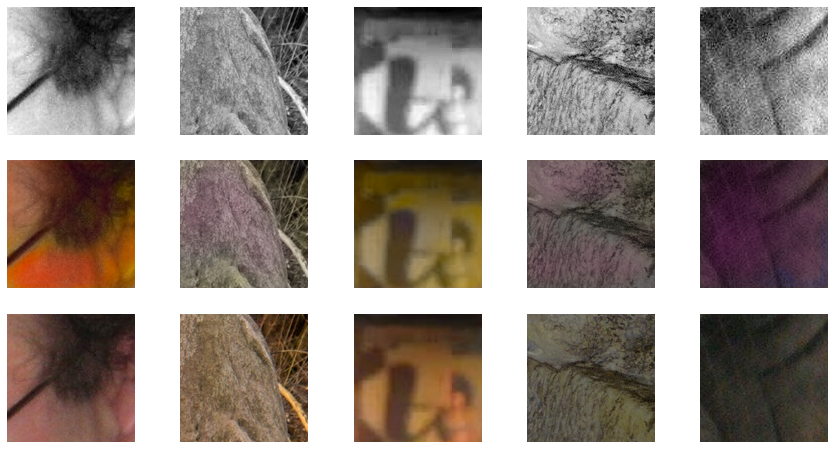

Validation Generator Loss: 12.258333206176758


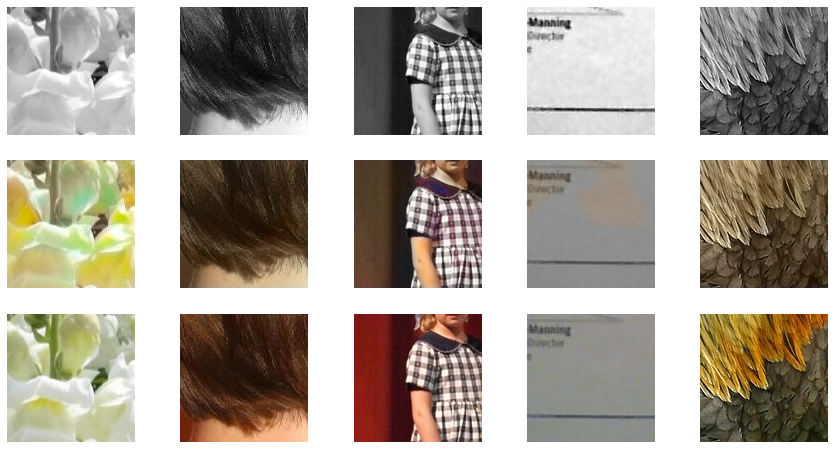

Validation Generator Loss: 12.714768409729004


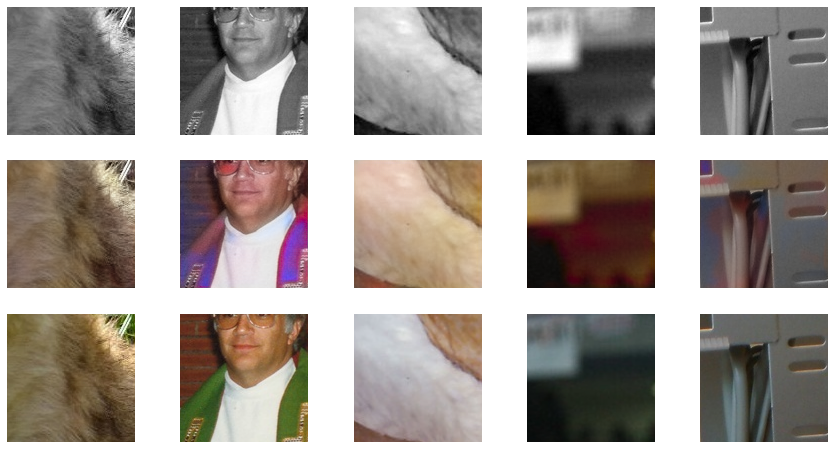

Validation Generator Loss: 12.348291397094727


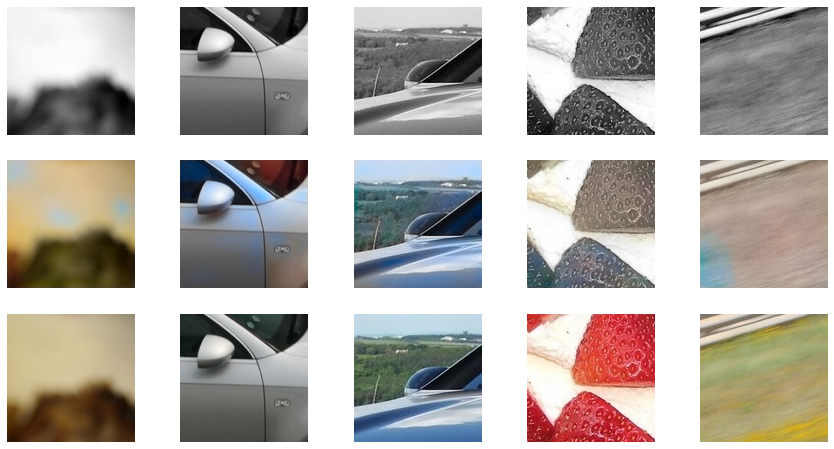

Validation Generator Loss: 12.578977584838867


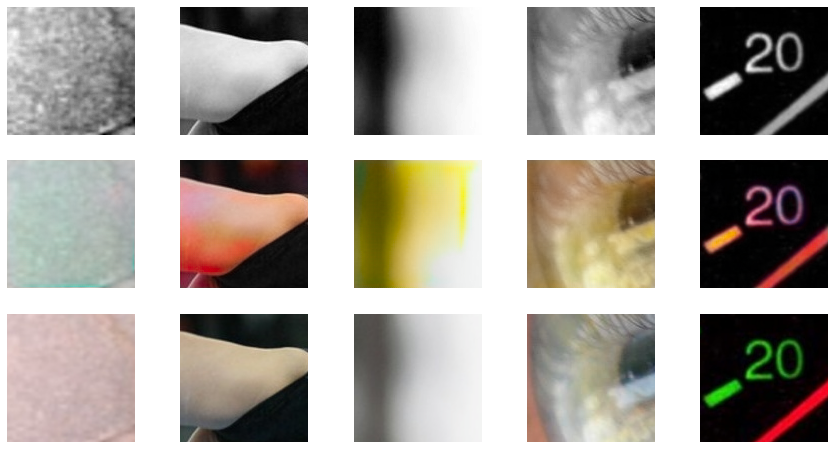

In [ ]:
model = GANColorizer(train_dataset, valid_dataset, validation_loader)

folder_path = "/content/drive/MyDrive/Projects/BW to Color/Models/"

trainer = pl.Trainer(
max_epochs = 10,
progress_bar_refresh_rate = 20,
gpus = 1,
# tpu_cores = 8,
# accumulate_grad_batches=2,
precision = 16,
move_metrics_to_cpu = True  
)

trainer.fit(model)

torch.save(model.net_G.state_dict(), f"{folder_path}generator.pth")
torch.save(model.state_dict(), f"{folder_path}gan.pth")